In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             matthews_corrcoef, roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder



In [2]:
################################################################################
# Definindo funções
################################################################################
def gerar_transacao(config: dict) -> list:
    """ 
    Gera uma linha de dados aleatórios de acordo com os parâmetros para
    cada variável, definida no dicionário de configuração. 
    :param config: Dicionário contendo as porcentagens de cada variável
    em caso de fraude.
    :return: Lista de valores aleatórios gerados para cada coluna do 
    dataframe a ser criado.
    """
    categoria = np.random.choice(list(config['categoria'].keys()))
    localizacao = np.random.choice(list(config['localizacao'].keys()))
    faixa_etaria = np.random.choice(list(config['faixa_etaria'].keys()))
    dia_semana = np.random.choice(list(config['dia_semana'].keys()))
    hora = np.random.choice(list(config['hora'].keys()))
    fraude_prob = np.mean([
        config['categoria'][categoria],
        config['localizacao'][localizacao],
        config['faixa_etaria'][faixa_etaria],
        config['dia_semana'][dia_semana],
        config['hora'][hora]
    ])
    fraude = np.random.rand() < fraude_prob
    if fraude:
        valor_transacao = np.random.uniform(*config['valor']['fraude'])
    else:
        valor_transacao = np.random.uniform(*config['valor']['legitimo'])
    return categoria, localizacao, faixa_etaria, dia_semana, hora, valor_transacao, fraude

def tratamento_hora(df: pd.DataFrame) -> pd.DataFrame:  
    """  
    Transforma o formato de hora com tipo e numeração ideal para análise.
    :param df: Dataframe com coluna de hora.
    :return: Dataframe com coluna de hora tratada.
    """
    df['hora'] = df['hora'].astype(str)
    df['hora_transacao'] = df['hora'].str.replace('h', '', regex=False)
    df['hora_transacao'] = pd.to_datetime(df['hora_transacao'], format='%H', errors='coerce')
    df['hora_transacao'] = df['hora_transacao'].dt.hour
    df = df.drop(columns=['hora'])
    return df

def tratamento_categoricas(df: pd.DataFrame, coluna: str) -> pd.DataFrame:
    """  
    Trata coluna de valor categórico para gerar colunas binárias de 
    classificação.
    :param df: Dataframe com coluna de dados categóricos.
    :param coluna: Nome da coluna a ser tratada.
    :return: Dataframe com coluna categórica trasnformada em colunas binárias.
    """
    encoded_array = encoder.fit_transform(df[[coluna]])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out([coluna]))
    df_final = pd.concat([df.drop(coluna, axis=1), encoded_df], axis=1)
    return df_final

In [3]:
################################################################################
# Definindo objetos
################################################################################

# Valores para o dataframe
n_transacoes = 10000
dados = {
    'categoria': [],
    'localizacao': [],
    'faixa_etaria': [],
    'dia_semana': [],
    'hora': [],
    'valor_transacao': [],
    'fraude': []
}
dados_config = {'localizacao': {
    'Norte': 0.034,
    'Nordeste': 0.028,
    'Centro-Oeste': 0.025,
    'Sudeste': 0.021,
    'Sul': 0.011},
    'categoria' : {
        'Celular': 0.082,
        'Eletrônicos': 0.080,
        'Informática': 0.043,
        'Automotivo': 0.034,
        'Eletrodomésticos': 0.033,
        'Acessórios': 0.030,
        'Móveis': 0.023,
        'Beleza': 0.022,
        'Esportes': 0.020,
        'Eletroportáteis': 0.020},
    'faixa_etaria': {
        'até 25 anos': 0.040,
        'entre 26 e 35 anos': 0.019,
        'entre 36 e 50 anos': 0.015,
        'acima de 51 anos': 0.021},
    'dia_semana': {
        'Domingo': 0.017,
        'Segunda': 0.021,
        'Terça': 0.022,
        'Quarta': 0.022,
        'Quinta': 0.022,
        'Sexta': 0.021,
        'Sábado': 0.020},
    'hora': {
        '00h': 0.036,
        '01h': 0.042,
        '02h': 0.069,
        '03h': 0.077,
        '04h': 0.067,
        '05h': 0.037,
        '06h': 0.014,
        '07h': 0.017,
        '08h': 0.014,
        '09h': 0.015,
        '10h': 0.016,
        '11h': 0.018,
        '12h': 0.020,
        '13h': 0.021,
        '14h': 0.021,
        '15h': 0.022,
        '16h': 0.023,
        '17h': 0.022,
        '18h': 0.022,
        '19h': 0.021,
        '20h': 0.021,
        '21h': 0.020,
        '22h': 0.021,
        '23h': 0.026},
    'valor': {'fraude': (500.00, 2000.00),
        'legitimo': (50.00, 700.00)}}

In [4]:
################################################################################
# Encoder e seed
################################################################################

np.random.seed(42)
encoder = OneHotEncoder(sparse_output=False)

In [5]:
################################################################################
# Iteração para geração de dataframe
################################################################################

for i in range(n_transacoes):
    categoria, localizacao, faixa_etaria, dia_semana, hora, valor_transacao, fraude = gerar_transacao(dados_config)
    transacao = {
        'categoria': categoria,
        'localizacao': localizacao,
        'faixa_etaria': faixa_etaria,
        'dia_semana': dia_semana,
        'hora': hora,
        'valor_transacao': valor_transacao,
        'fraude': fraude
    }
    for key, value in transacao.items():
        dados[key].append(value)
df = pd.DataFrame(dados)

In [6]:
################################################################################
# Verificando as colunas do dataframe
################################################################################

print(df.head())

         categoria   localizacao        faixa_etaria dia_semana hora  \
0           Móveis       Sudeste         até 25 anos     Sábado  10h   
1  Eletroportáteis  Centro-Oeste  entre 36 e 50 anos      Terça  10h   
2           Beleza  Centro-Oeste  entre 26 e 35 anos     Quinta  01h   
3      Eletrônicos       Sudeste         até 25 anos    Domingo  11h   
4         Esportes         Norte  entre 36 e 50 anos      Terça  09h   

   valor_transacao  fraude  
0       437.952603   False  
1       440.724758   False  
2       660.059261   False  
3        54.593098   False  
4       682.941087   False  


In [7]:
################################################################################
# Tratamento de colunas
################################################################################

df_data = tratamento_hora(df)
df_cat = tratamento_categoricas(df_data, 'categoria')
df_loc = tratamento_categoricas(df_cat, 'localizacao')
df_faixa = tratamento_categoricas(df_loc, 'faixa_etaria')
df_transacoes = tratamento_categoricas(df_faixa, 'dia_semana')

In [8]:
################################################################################
# Verificando o dataframe gerado
################################################################################

df_transacoes

,valor_transacao,fraude,hora_transacao,categoria_Acessórios,categoria_Automotivo,categoria_Beleza,categoria_Celular,categoria_Eletrodomésticos,categoria_Eletroportáteis,categoria_Eletrônicos,...,faixa_etaria_até 25 anos,faixa_etaria_entre 26 e 35 anos,faixa_etaria_entre 36 e 50 anos,dia_semana_Domingo,dia_semana_Quarta,dia_semana_Quinta,dia_semana_Segunda,dia_semana_Sexta,dia_semana_Sábado,dia_semana_Terça
0,437.952603,False,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,440.724758,False,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,660.059261,False,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,54.593098,False,11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,682.941087,False,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,217.340580,False,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,273.640842,False,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,68.896961,False,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9998,1400.769500,True,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
################################################################################
# Verificando a quantidade de fraudes nos dados
################################################################################

print(df_transacoes['fraude'].value_counts()) 

fraude
False    9733
True      267
Name: count, dtype: int64


In [10]:
################################################################################
# Gerando divisão dos dados sem método SMOTE
################################################################################

X = df_transacoes.drop(['fraude'], axis=1) 
y = df_transacoes['fraude']

In [11]:
################################################################################
# Criando o modelo
################################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rl = LogisticRegression(max_iter=500, C=0.1)
rl.fit(X_train, y_train)



LogisticRegression(C=0.1, max_iter=500)

In [12]:

################################################################################
# Avaliação do modelo
################################################################################

y_pred_proba = rl.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_score}")

y_pred = rl.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", conf_matrix)

cv_scores = cross_val_score(rl, X_train, y_train, cv=5, scoring='accuracy')
print("Validação cruzada: ", cv_scores)
print("Acurácia média: ", cv_scores.mean())
print("Desvio padrão: ", cv_scores.std())
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Coeficiente de correlação: {mcc}")


AUC-ROC: 0.9727488732118361
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      2916
        True       1.00      0.82      0.90        84

    accuracy                           0.99      3000
   macro avg       1.00      0.91      0.95      3000
weighted avg       1.00      0.99      0.99      3000

Matriz de Confusão:
 [[2916    0]
 [  15   69]]
Validação cruzada:  [0.99785714 0.995      0.995      0.995      0.99071429]
Acurácia média:  0.9947142857142858
Desvio padrão:  0.002285714285714274
Coeficiente de correlação: 0.9040048343118147


              precision    recall  f1-score   support

       False       0.99      1.00      1.00      2916
        True       1.00      0.82      0.90        84

    accuracy                           0.99      3000
   macro avg       1.00      0.91      0.95      3000
weighted avg       1.00      0.99      0.99      3000

ROC AUC: 0.9727488732118361


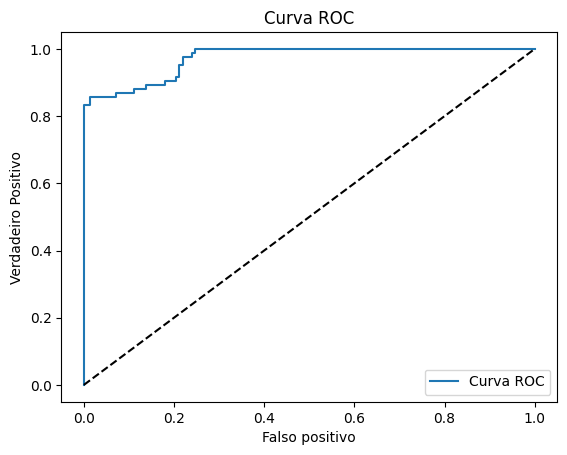

In [13]:
################################################################################
# Curva ROC
################################################################################

y_pred = rl.predict(X_test)
y_prob = rl.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.show()
